In [152]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

best_acc1 = 0

def modelOutputs(modelPath,data,gpu=0,arch="resnet50",outputLayers=101,batch_size=1):
    global best_acc1
    
    modelNums=range(0,10)
    modelPaths = []
    for m in modelNums:
        modelPaths.append(os.path.join(modelPath, "model" + str(m), "model_best.pth.tar"))

    if gpu is not None:
        print("Use GPU: {}".format(gpu))

    # create model
    print("=> using pre-trained model '{}'".format(arch))
    model = models.__dict__[arch]()
    model.fc = nn.Linear(2048,outputLayers,bias=True)

    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
    else:
        model.to("cpu")
        print("Not using GPU")

    # define loss function (criterion) and optimizer
    if gpu is None:
        criterion = nn.CrossEntropyLoss().to("cpu")
    else:
        criterion = nn.CrossEntropyLoss().cuda(gpu)
    optimizer = torch.optim.Adam(model.parameters())

    cudnn.benchmark = True

    # Data loading code
    testdir = os.path.join(data, 'test')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(testdir, transforms.Compose([
            #transforms.Resize(256),
            #transforms.CenterCrop(224),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=False, pin_memory=True)
    
    #load each model
    totalOutputs = []
    for loadModel in modelPaths:
        if gpu is None:
            checkpoint = torch.load(loadModel)
        else:
            # Map model to be loaded to specified single gpu.
            loc = 'cuda:{}'.format(gpu)
            checkpoint = torch.load(loadModel, map_location=loc)
        start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['best_acc1']
        if gpu is not None:
            # best_acc1 may be from a checkpoint from a different GPU
            best_acc1 = best_acc1.to(gpu)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded model '{}' (epoch {})"
              .format(loadModel, checkpoint['epoch']))


        outputs,targets = validate(test_loader, model, criterion, gpu)

        totalOutputs.append(outputs)
        
    return totalOutputs, targets

def validate(val_loader, model, criterion, gpu, display=False):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    outputs = []
    targets = []
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if gpu is not None:
                images = images.cuda(gpu, non_blocking=True)
                target = target.cuda(gpu, non_blocking=True)
            #if torch.cuda.is_available():
            #    target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            for out in output:
                outputs.append(out.detach().to("cpu").numpy())
            for tar in target:
                targets.append(target.to("cpu").numpy())
            #torch.save(output,"output-model" + str(modelNum) + ".pt");
            # measure accuracy and record loss
            if(display):
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
                losses.update(loss.item(), images.size(0))
                top1.update(acc1[0], images.size(0))
                top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


        if(display):
            print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
                  .format(top1=top1, top5=top5))

    return outputs,targets#top1.avg, top5.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,5)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [161]:
rgbOutputs, targets = modelOutputs("../DeepEnsemble/caltech101", "../caltech101",outputLayers=101)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 118)
=> loaded model '../DeepEnsemble/caltech101/model1/model_best.pth.tar' (epoch 83)
=> loaded model '../DeepEnsemble/caltech101/model2/model_best.pth.tar' (epoch 67)
=> loaded model '../DeepEnsemble/caltech101/model3/model_best.pth.tar' (epoch 70)
=> loaded model '../DeepEnsemble/caltech101/model4/model_best.pth.tar' (epoch 108)
=> loaded model '../DeepEnsemble/caltech101/model5/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/caltech101/model6/model_best.pth.tar' (epoch 80)
=> loaded model '../DeepEnsemble/caltech101/model7/model_best.pth.tar' (epoch 96)
=> loaded model '../DeepEnsemble/caltech101/model8/model_best.pth.tar' (epoch 97)
=> loaded model '../DeepEnsemble/caltech101/model9/model_best.pth.tar' (epoch 61)


In [257]:
lineOutputs, targets = modelOutputs("../DeepEnsemble/caltech101", "../caltech101/shape",outputLayers=101)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 118)
=> loaded model '../DeepEnsemble/caltech101/model1/model_best.pth.tar' (epoch 83)
=> loaded model '../DeepEnsemble/caltech101/model2/model_best.pth.tar' (epoch 67)
=> loaded model '../DeepEnsemble/caltech101/model3/model_best.pth.tar' (epoch 70)
=> loaded model '../DeepEnsemble/caltech101/model4/model_best.pth.tar' (epoch 108)
=> loaded model '../DeepEnsemble/caltech101/model5/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/caltech101/model6/model_best.pth.tar' (epoch 80)
=> loaded model '../DeepEnsemble/caltech101/model7/model_best.pth.tar' (epoch 96)
=> loaded model '../DeepEnsemble/caltech101/model8/model_best.pth.tar' (epoch 97)
=> loaded model '../DeepEnsemble/caltech101/model9/model_best.pth.tar' (epoch 61)


In [258]:
stylizedOutputs, targets = modelOutputs("../DeepEnsemble/caltech101", "../caltech101/stylized",outputLayers=101)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 118)
=> loaded model '../DeepEnsemble/caltech101/model1/model_best.pth.tar' (epoch 83)
=> loaded model '../DeepEnsemble/caltech101/model2/model_best.pth.tar' (epoch 67)
=> loaded model '../DeepEnsemble/caltech101/model3/model_best.pth.tar' (epoch 70)
=> loaded model '../DeepEnsemble/caltech101/model4/model_best.pth.tar' (epoch 108)
=> loaded model '../DeepEnsemble/caltech101/model5/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/caltech101/model6/model_best.pth.tar' (epoch 80)
=> loaded model '../DeepEnsemble/caltech101/model7/model_best.pth.tar' (epoch 96)
=> loaded model '../DeepEnsemble/caltech101/model8/model_best.pth.tar' (epoch 97)
=> loaded model '../DeepEnsemble/caltech101/model9/model_best.pth.tar' (epoch 61)


In [290]:
shuffledOutputs, targets = modelOutputs("../DeepEnsemble/caltech101", "../caltech101/shuffled",outputLayers=101)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 118)
=> loaded model '../DeepEnsemble/caltech101/model1/model_best.pth.tar' (epoch 83)
=> loaded model '../DeepEnsemble/caltech101/model2/model_best.pth.tar' (epoch 67)
=> loaded model '../DeepEnsemble/caltech101/model3/model_best.pth.tar' (epoch 70)
=> loaded model '../DeepEnsemble/caltech101/model4/model_best.pth.tar' (epoch 108)
=> loaded model '../DeepEnsemble/caltech101/model5/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/caltech101/model6/model_best.pth.tar' (epoch 80)
=> loaded model '../DeepEnsemble/caltech101/model7/model_best.pth.tar' (epoch 96)
=> loaded model '../DeepEnsemble/caltech101/model8/model_best.pth.tar' (epoch 97)
=> loaded model '../DeepEnsemble/caltech101/model9/model_best.pth.tar' (epoch 61)


In [533]:
#Average over model outputs
rgbAveraged = np.mean(rgbOutputs,axis=0)
rgbStd = np.std(rgbOutputs,axis=0)
print(accuracy(torch.FloatTensor(rgbAveraged),torch.FloatTensor(targets),(1,5)))
rgbProbs = soft(torch.FloatTensor(rgbAveraged)).numpy()
rgbStdProbs = soft(torch.FloatTensor(rgbStd)).numpy()

[tensor([74.0396]), tensor([89.0570])]


In [259]:
#Average over model outputs
av = np.mean(lineOutputs,axis=0)
std = np.std(lineOutputs,axis=0)
print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
lineProbs = soft(torch.FloatTensor(av)).numpy()
lineStdProbs = soft(torch.FloatTensor(std)).numpy()

[tensor([25.8440]), tensor([44.1211])]


In [260]:
#Average over model outputs
av = np.mean(stylizedOutputs,axis=0)
std = np.std(stylizedOutputs,axis=0)
print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
stylizedProbs = soft(torch.FloatTensor(av)).numpy()
stylizedStdProbs = soft(torch.FloatTensor(std)).numpy()

[tensor([49.8254]), tensor([69.1502])]


In [291]:
#Average over model outputs
av = np.mean(shuffledOutputs,axis=0)
std = np.std(shuffledOutputs,axis=0)
print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
shuffledProbs = soft(torch.FloatTensor(av)).numpy()
shuffledStdProbs = soft(torch.FloatTensor(std)).numpy()

[tensor([1.8626]), tensor([4.6566])]


In [269]:
vals,indices = np.unique(targets,return_index=True)

In [289]:
cmap=sns.color_palette(palette="viridis",as_cmap=True)

In [457]:
def plot(data):
    plt.figure(figsize=(14,7))
    sns.heatmap(data,cmap=cmap)
    #plt.show()

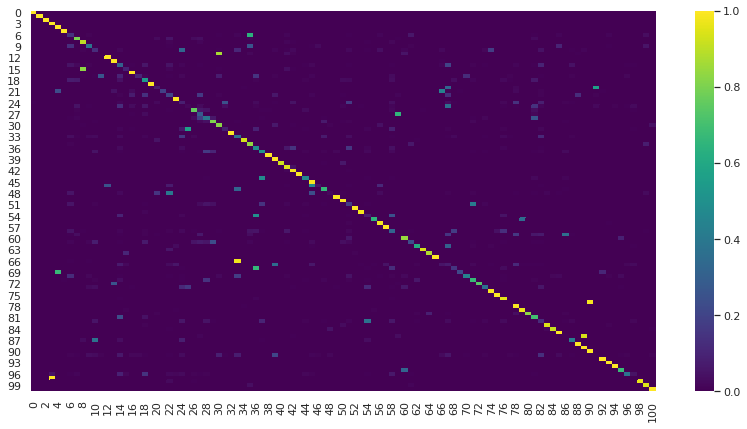

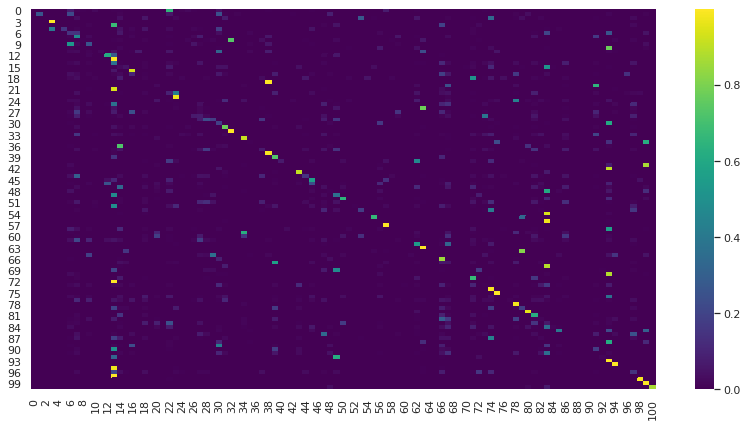

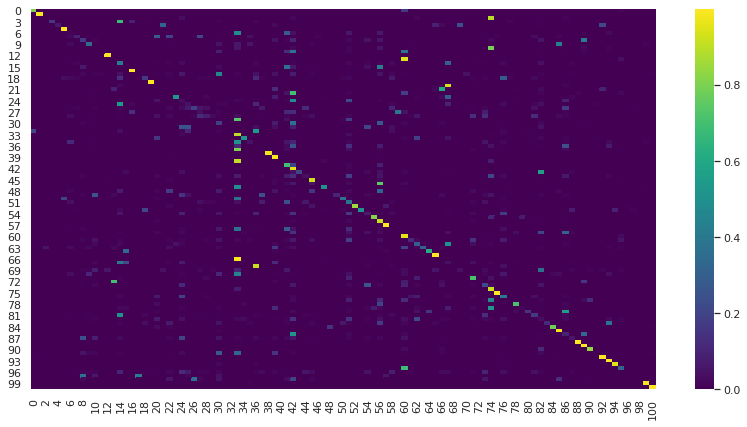

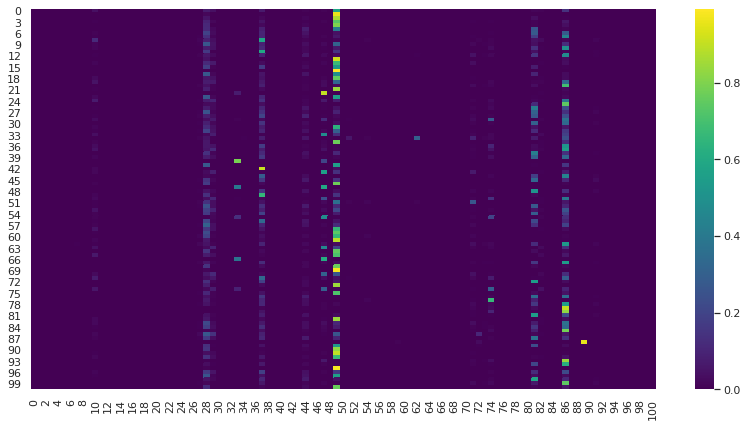

In [458]:
plot(rgbProbs[indices])
plot(lineProbs[indices])
plot(stylizedProbs[indices])
plot(shuffledProbs[indices])

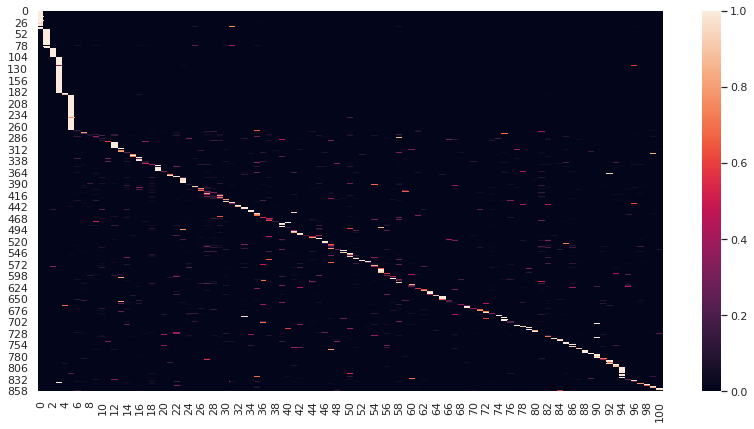

In [294]:
plt.figure(figsize=(14,7))
sns.heatmap(rgbProbs)
plt.show()

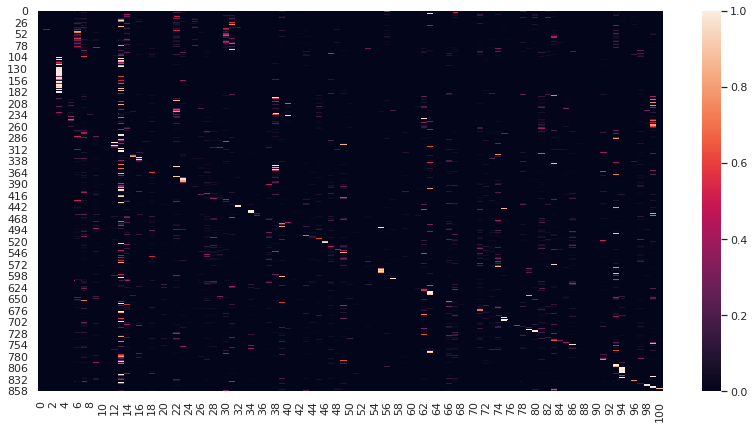

In [264]:
plt.figure(figsize=(14,7))
sns.heatmap(lineProbs)
plt.show()

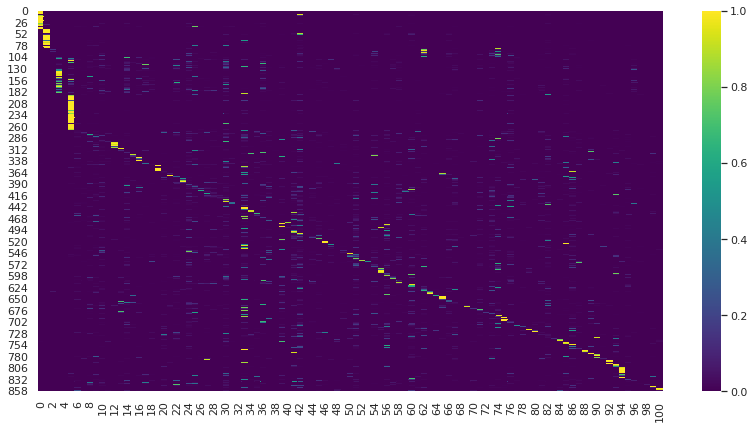

In [286]:
plt.figure(figsize=(14,7))
sns.heatmap(stylizedProbs,cmap=cmap)
plt.show()

In [297]:
v,ind = torch.FloatTensor(rgbProbs).topk(1)
v = v.numpy()
ind = ind.numpy()

In [305]:
np.shape(rgbProbs[0]),np.shape(rgbStdProbs),len(rgbProbs)

((101,), (859, 101), 859)

In [404]:
def getY(data,ind):
    indind=0
    y=[]
    for val in data:
        y.append(val[ind[indind]][0])
        indind+=1
    return y

def getTopIndices(vals):
    v,ind = torch.FloatTensor(vals).topk(1)
    #v = v.numpy()
    ind = ind.numpy()
    return ind

def errPlot(probs,std):
    ind = getTopIndices(probs)

    y = getY(probs,ind)
    #print(y)
    err = getY(std,ind)
    #print(err)
    plt.figure(figsize=(14,7))
    plt.bar(range(len(y)),height=y,yerr=np.multiply(err,1))#,yerr=rgbStdProbs[ind])
    plt.xticks(range(1,len(y)+1,2),rotation="45")
    plt.show()

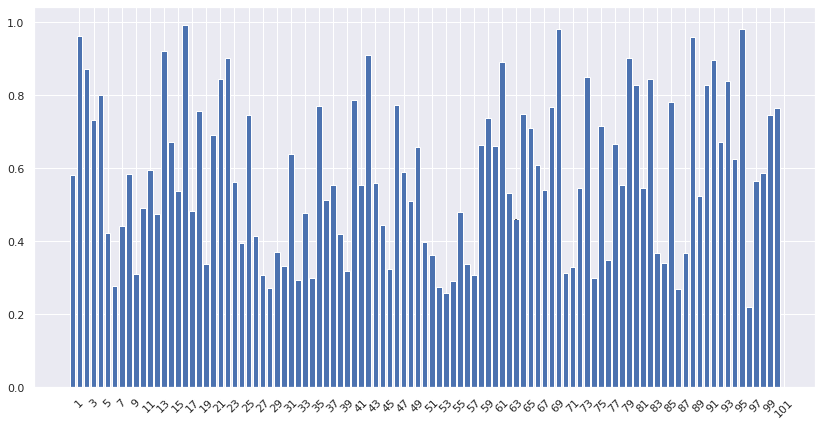

In [405]:
errPlot(shuffledProbs[indices],shuffledStdProbs[indices])

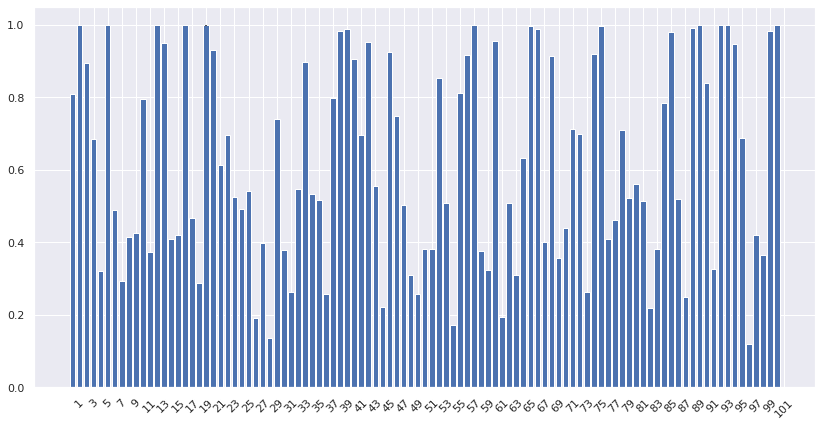

In [401]:
errPlot(stylizedProbs[indices],stylizedStdProbs[indices])

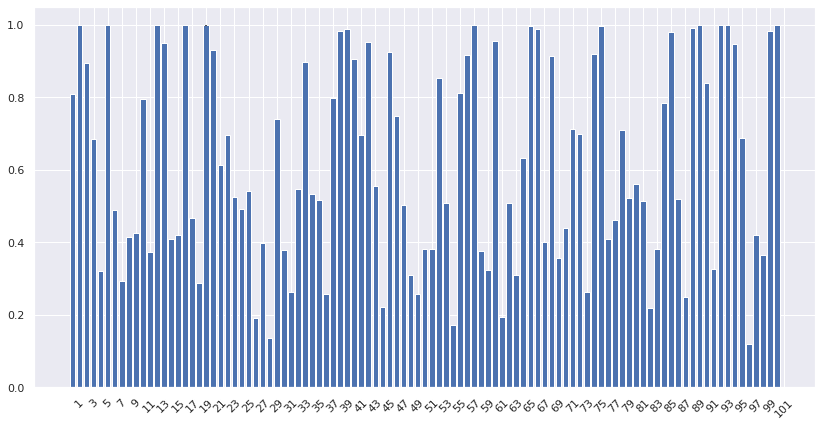

In [402]:
errPlot(stylizedProbs[indices],stylizedStdProbs[indices])

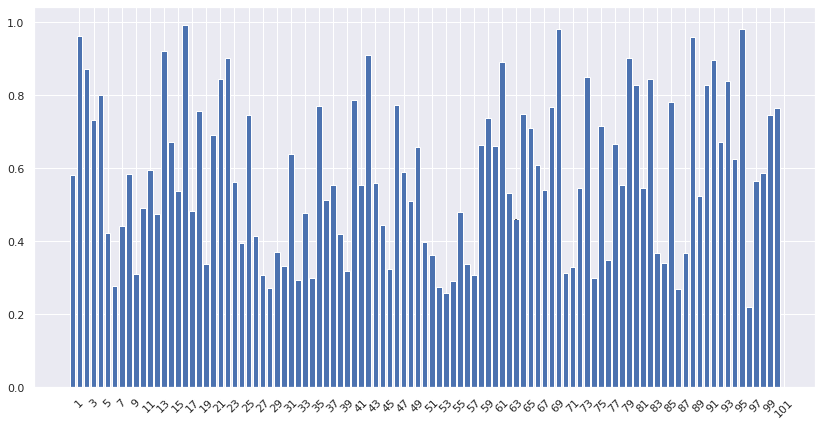

In [403]:
errPlot(shuffledProbs[indices],shuffledStdProbs[indices])

In [450]:
def saveFig(filename):
    plt.savefig(filename + ".png",format="png")

def plotStds(eachProbStd,labels,dataSet):
    plt.figure(figsize=(14,7))
    
    for prob,std in eachProbStd:
        topInd = getTopIndices(prob[indices])
        y=getY(std[indices],topInd)
        plt.scatter(x=range(len(y)), y=y)
    plt.legend(labels)
    #plt.show()
    saveFig(dataSet + "_std")

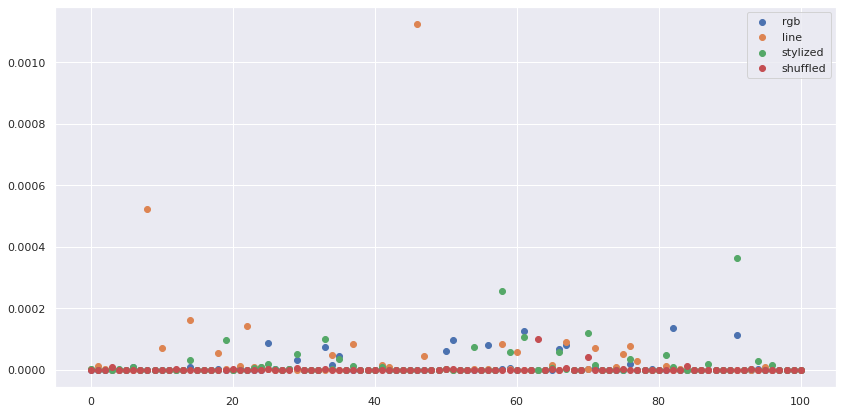

In [452]:
labels=["rgb","line","stylized","shuffled"]
plotStds([[rgbProbs,rgbStdProbs],[lineProbs,lineStdProbs],[stylizedProbs,stylizedStdProbs],[shuffledProbs,shuffledStdProbs]],labels,"caltech101")

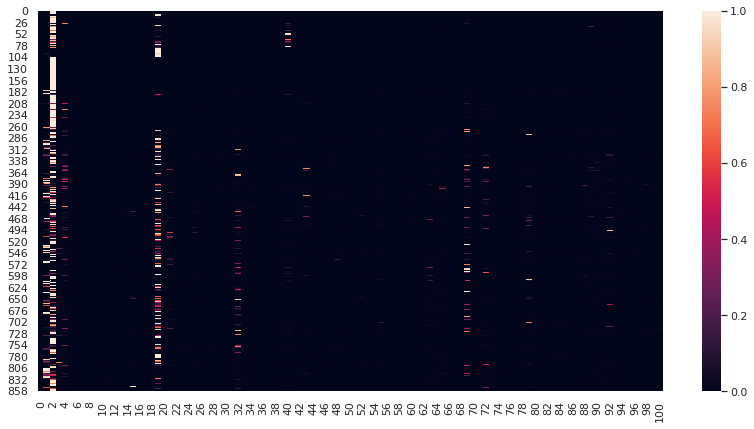

In [432]:
plt.figure(figsize=(14,7))
sns.heatmap(rgbStdProbs)
plt.show()

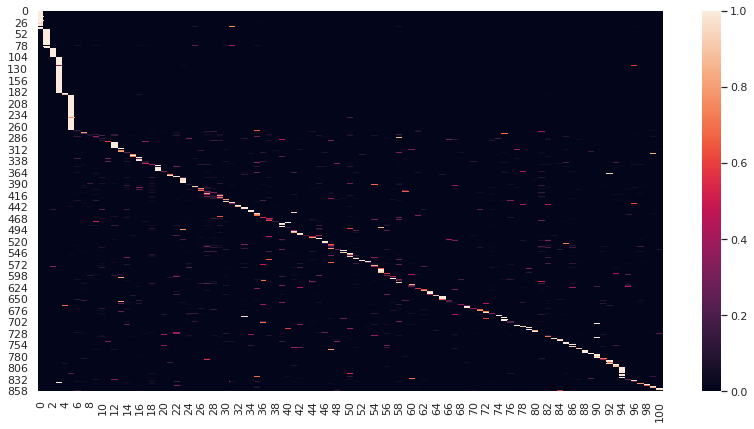

In [433]:
plt.figure(figsize=(14,7))
sns.heatmap(probs)
plt.show()

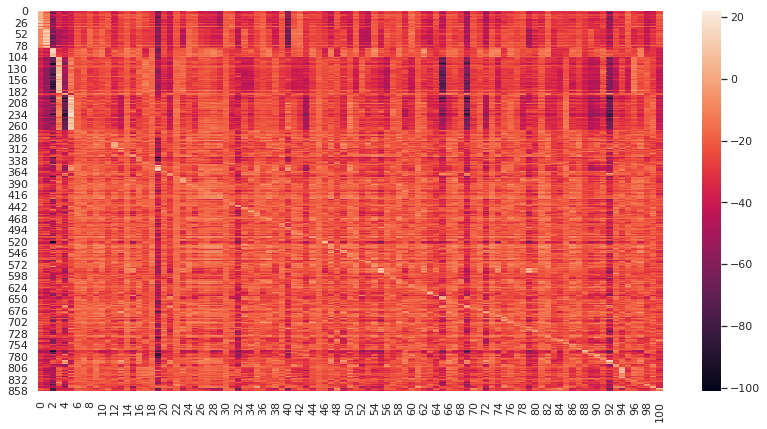

In [434]:
plt.figure(figsize=(14,7))
sns.heatmap(averaged)
plt.show()

In [468]:
def saveFig(filename):
    plt.savefig("figures/"+filename + ".png",format="png")

def heatmapPlot(data,filename):
    plt.figure(figsize=(14,7))
    sns.heatmap(data,cmap=cmap)
    plt.ylabel("Test Image")
    plt.xlabel("Class Predictions for Test Image")
    saveFig(filename + "_predictions")
    #plt.show()
    
def getY(data,ind):
    indind=0
    y=[]
    for val in data:
        y.append(val[ind[indind]][0])
        indind+=1
    return y

def getTopIndices(vals):
    v,ind = torch.FloatTensor(vals).topk(1)
    #v = v.numpy()
    ind = ind.numpy()
    return ind

def errPlot(probs,std):
    ind = getTopIndices(probs)

    y = getY(probs,ind)
    #print(y)
    err = getY(std,ind)
    #print(err)
    plt.figure(figsize=(14,7))
    plt.bar(range(len(y)),height=y,yerr=np.multiply(err,1))#,yerr=rgbStdProbs[ind])
    plt.xticks(range(1,len(y)+1,2),rotation="45")
    plt.show()

def plotStds(indices,eachProbStd,labels,dataSet):
    plt.figure(figsize=(14,7))
    
    for prob,std in eachProbStd:
        topInd = getTopIndices(prob[indices])
        y=getY(std[indices],topInd)
        plt.scatter(x=range(len(y)), y=y)
    plt.legend(labels)
    plt.ylabel("Standard Deviation for Top Predicted Label")
    plt.xlabel("Test Images")
    #plt.show()
    saveFig(dataSet + "_prediction_std")
    
def createPlots(dataName,numOutputs):
    ###Load models and run tests
    dataLocation = "../DeepEnsemble/"+dataName
    rgbOutputs, targets = modelOutputs(dataLocation, "../" + dataName,outputLayers=numOutputs)
    lineOutputs, targets = modelOutputs(dataLocation, "../" + dataName + "/shape",outputLayers=numOutputs)
    stylizedOutputs, targets = modelOutputs(dataLocation, "../" + dataName + "/stylized",outputLayers=numOutputs)
    shuffledOutputs, targets = modelOutputs(dataLocation, "../" + dataName + "/shuffled",outputLayers=numOutputs)
    
    soft = nn.Softmax(dim=1)
    
    ###Get important information (mean, std)
    rgbAveraged = np.mean(rgbOutputs,axis=0)
    rgbStd = np.std(rgbOutputs,axis=0)
    print(accuracy(torch.FloatTensor(rgbAveraged),torch.FloatTensor(targets),(1,5)))
    rgbProbs = soft(torch.FloatTensor(rgbAveraged)).numpy()
    rgbStdProbs = soft(torch.FloatTensor(rgbStd)).numpy()
    
    av = np.mean(lineOutputs,axis=0)
    std = np.std(lineOutputs,axis=0)
    print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
    lineProbs = soft(torch.FloatTensor(av)).numpy()
    lineStdProbs = soft(torch.FloatTensor(std)).numpy()
    
    av = np.mean(stylizedOutputs,axis=0)
    std = np.std(stylizedOutputs,axis=0)
    print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
    stylizedProbs = soft(torch.FloatTensor(av)).numpy()
    stylizedStdProbs = soft(torch.FloatTensor(std)).numpy()
    
    av = np.mean(shuffledOutputs,axis=0)
    std = np.std(shuffledOutputs,axis=0)
    print(accuracy(torch.FloatTensor(av),torch.FloatTensor(targets),(1,5)))
    shuffledProbs = soft(torch.FloatTensor(av)).numpy()
    shuffledStdProbs = soft(torch.FloatTensor(std)).numpy()
    
    #Get one representative from each class to clear up the heatmaps
    vals,indices = np.unique(targets,return_index=True)
    cmap=sns.color_palette(palette="viridis",as_cmap=True)
    
    #Heatmaps
    heatmapPlot(rgbProbs[indices],dataName + "_rgb")
    heatmapPlot(lineProbs[indices],dataName + "_contour")
    heatmapPlot(stylizedProbs[indices],dataName + "_stylized")
    heatmapPlot(shuffledProbs[indices],dataName + "shuffled")
    
    #Plot standard deviations since they are too low to see in general
    labels=["rgb","line","stylized","shuffled"]
    plotStds(indices,[[rgbProbs,rgbStdProbs],[lineProbs,lineStdProbs],[stylizedProbs,stylizedStdProbs],[shuffledProbs,shuffledStdProbs]],labels,dataName)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 118)
=> loaded model '../DeepEnsemble/caltech101/model1/model_best.pth.tar' (epoch 83)
=> loaded model '../DeepEnsemble/caltech101/model2/model_best.pth.tar' (epoch 67)
=> loaded model '../DeepEnsemble/caltech101/model3/model_best.pth.tar' (epoch 70)
=> loaded model '../DeepEnsemble/caltech101/model4/model_best.pth.tar' (epoch 108)
=> loaded model '../DeepEnsemble/caltech101/model5/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/caltech101/model6/model_best.pth.tar' (epoch 80)
=> loaded model '../DeepEnsemble/caltech101/model7/model_best.pth.tar' (epoch 96)
=> loaded model '../DeepEnsemble/caltech101/model8/model_best.pth.tar' (epoch 97)
=> loaded model '../DeepEnsemble/caltech101/model9/model_best.pth.tar' (epoch 61)
Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech101/model0/model_best.pth.tar' (epoch 11

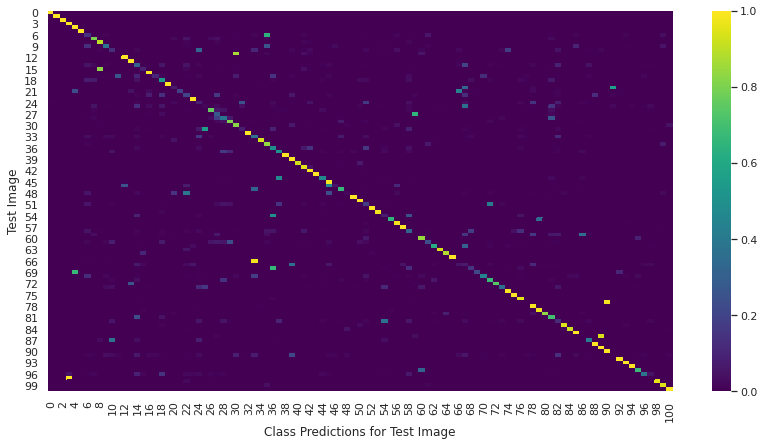

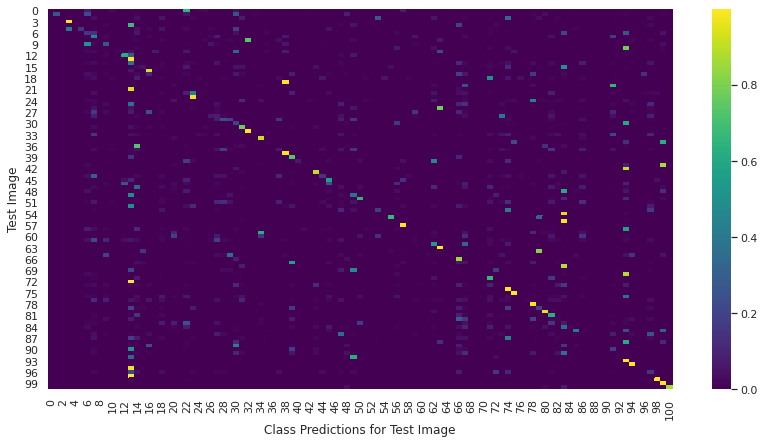

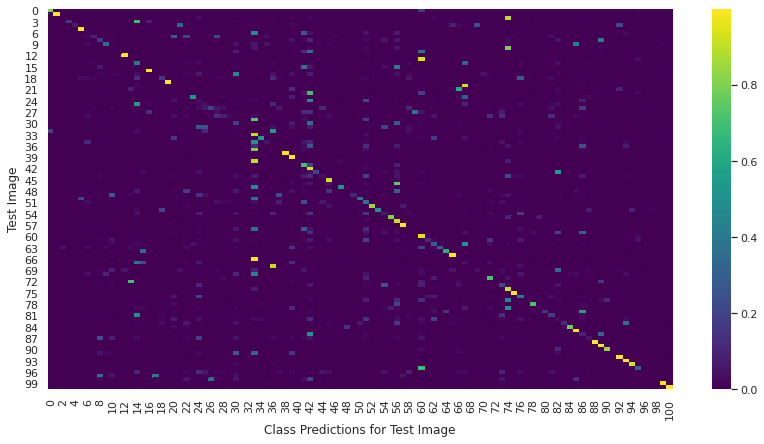

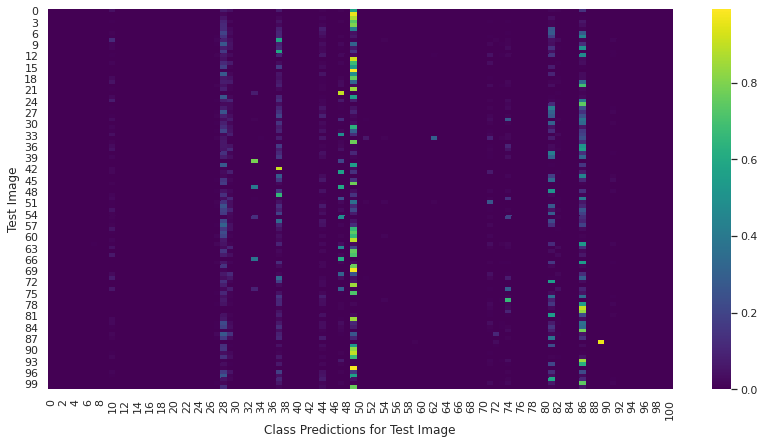

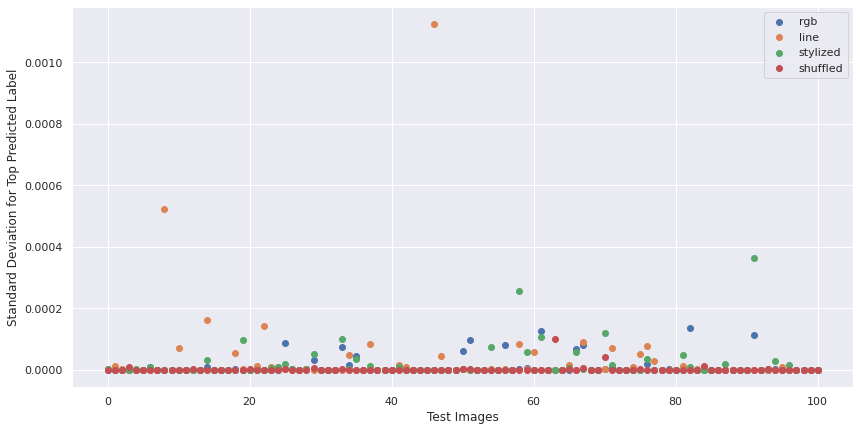

In [469]:
createPlots("caltech101",101)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech256/model0/model_best.pth.tar' (epoch 254)
=> loaded model '../DeepEnsemble/caltech256/model1/model_best.pth.tar' (epoch 239)
=> loaded model '../DeepEnsemble/caltech256/model2/model_best.pth.tar' (epoch 151)
=> loaded model '../DeepEnsemble/caltech256/model3/model_best.pth.tar' (epoch 1)
=> loaded model '../DeepEnsemble/caltech256/model4/model_best.pth.tar' (epoch 166)
=> loaded model '../DeepEnsemble/caltech256/model5/model_best.pth.tar' (epoch 2)
=> loaded model '../DeepEnsemble/caltech256/model6/model_best.pth.tar' (epoch 246)
=> loaded model '../DeepEnsemble/caltech256/model7/model_best.pth.tar' (epoch 3)
=> loaded model '../DeepEnsemble/caltech256/model8/model_best.pth.tar' (epoch 4)
=> loaded model '../DeepEnsemble/caltech256/model9/model_best.pth.tar' (epoch 17)
Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/caltech256/model0/model_best.pth.tar' (epoch 254

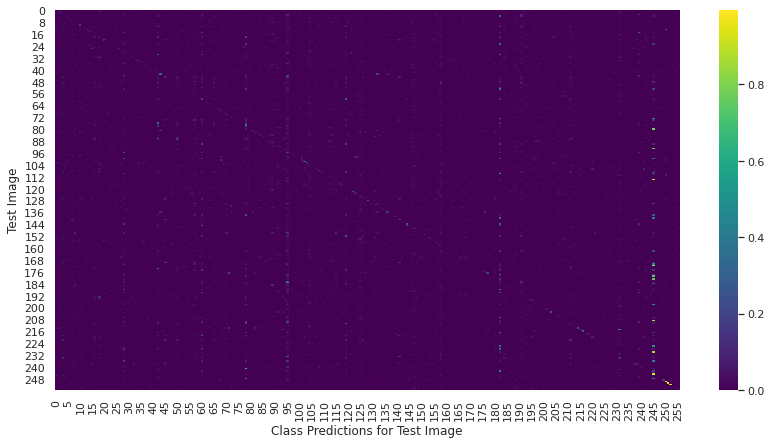

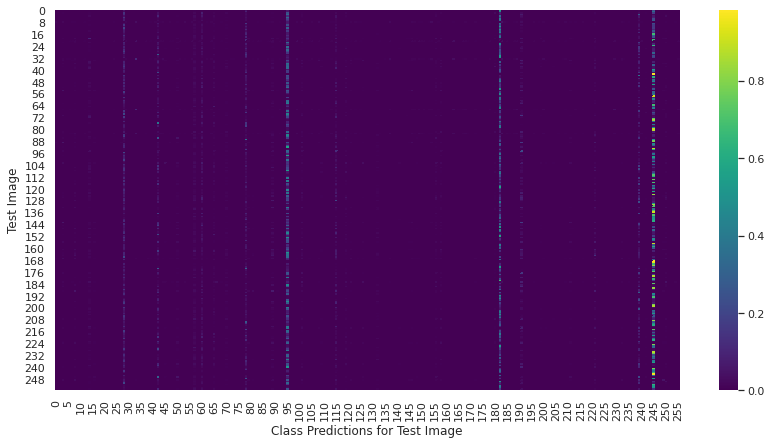

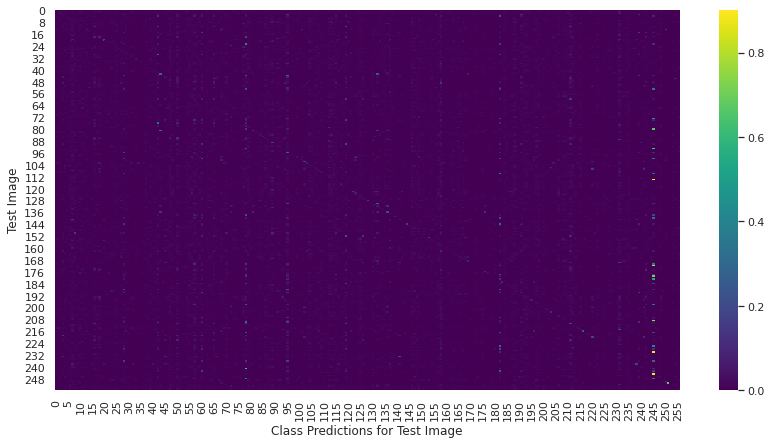

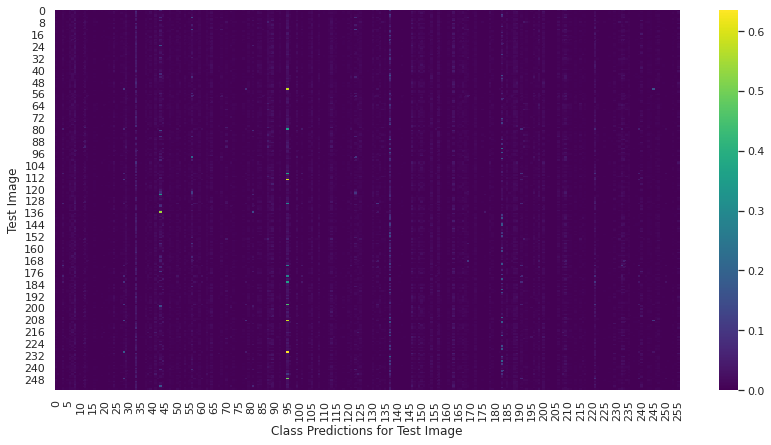

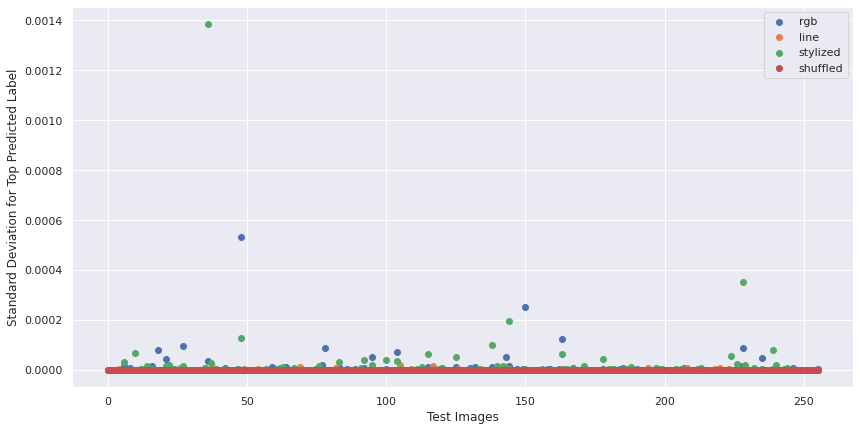

In [470]:
createPlots("caltech256",256)

Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/mit67/model0/model_best.pth.tar' (epoch 63)
=> loaded model '../DeepEnsemble/mit67/model1/model_best.pth.tar' (epoch 88)
=> loaded model '../DeepEnsemble/mit67/model2/model_best.pth.tar' (epoch 198)
=> loaded model '../DeepEnsemble/mit67/model3/model_best.pth.tar' (epoch 61)
=> loaded model '../DeepEnsemble/mit67/model4/model_best.pth.tar' (epoch 178)
=> loaded model '../DeepEnsemble/mit67/model5/model_best.pth.tar' (epoch 153)
=> loaded model '../DeepEnsemble/mit67/model6/model_best.pth.tar' (epoch 11)
=> loaded model '../DeepEnsemble/mit67/model7/model_best.pth.tar' (epoch 200)
=> loaded model '../DeepEnsemble/mit67/model8/model_best.pth.tar' (epoch 62)
=> loaded model '../DeepEnsemble/mit67/model9/model_best.pth.tar' (epoch 63)
Use GPU: 0
=> using pre-trained model 'resnet50'
=> loaded model '../DeepEnsemble/mit67/model0/model_best.pth.tar' (epoch 63)
=> loaded model '../DeepEnsemble/mit67/model1/model

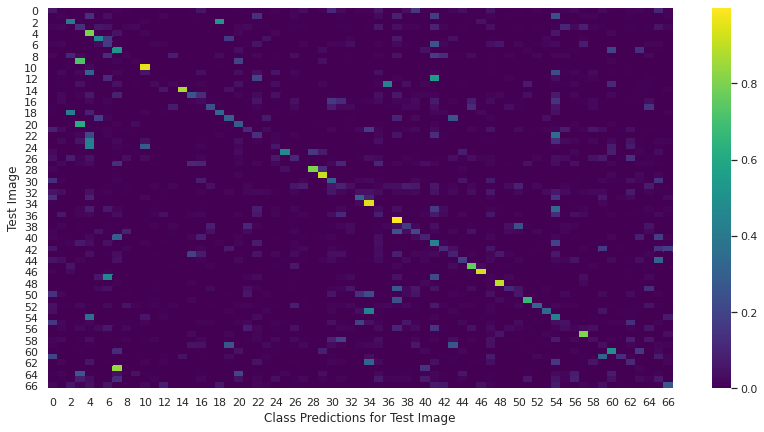

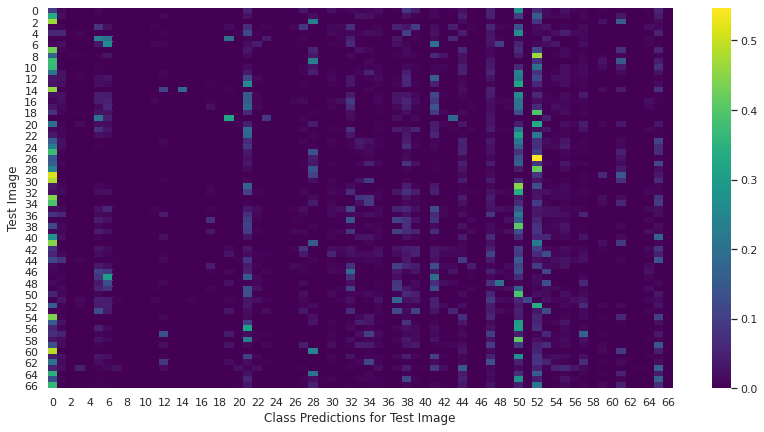

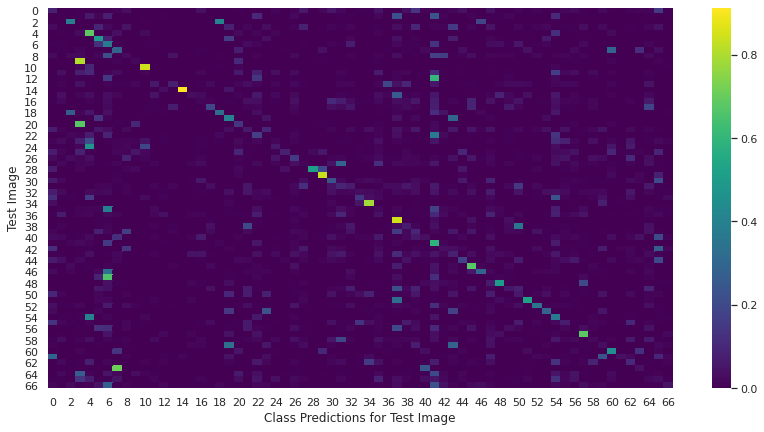

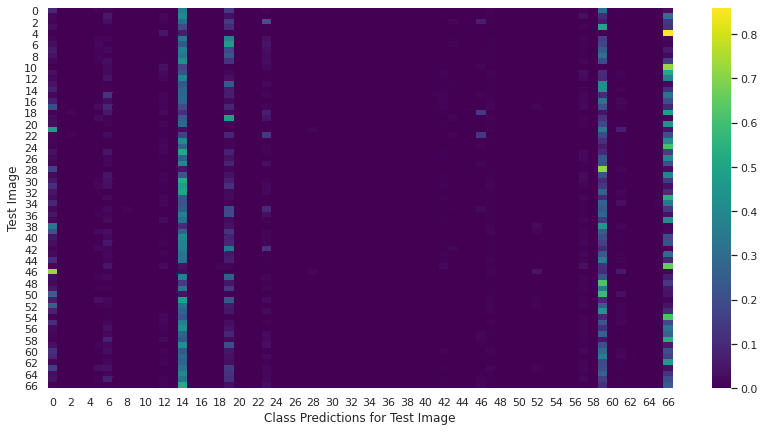

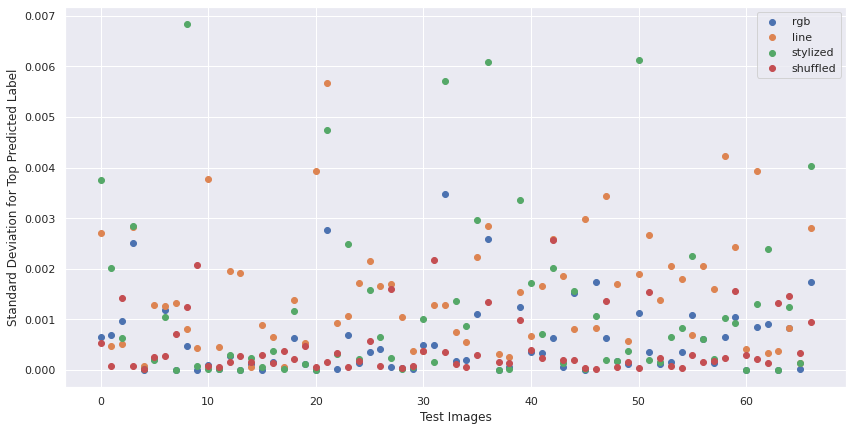

In [471]:
createPlots("mit67",67)

In [581]:
top1s = [[74.04,25.84,49.83,1.86],[25.21,2.43,18.22,1.12],[47.18, 10.26,40.13,3.65]]

In [582]:
x = pd.DataFrame(top1s,columns=labels,index=["101","256","67"]).T
x["101"]

rgb         74.04
line        25.84
stylized    49.83
shuffled     1.86
Name: 101, dtype: float64

In [558]:
def getAvStd(probs,stds):
    y=[]
    indind=0
    #topInds = getTopIndices(probs)
    topInds = targets
    for val in stds:
        #print(topInds[indind][0])
        y.append(val[topInds[indind][0]])
        indind+=1  
    return np.mean(y)

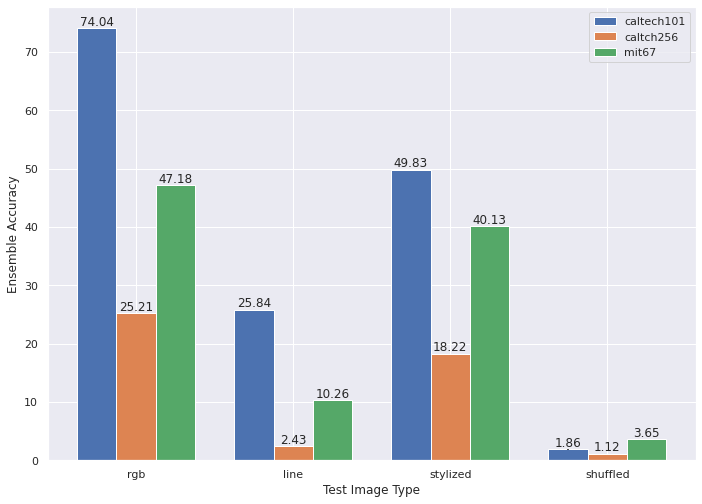

In [583]:
fig = plt.figure(figsize=(10,7))
X = np.arange(4)
ax = fig.add_axes([0.075,0.075,.9,.9])
yerr=[getAvStd(rgbAveraged,rgbStdProbs),getAvStd(lineProbs,lineStdProbs),getAvStd(stylizedProbs,stylizedStdProbs),getAvStd(shuffledProbs,shuffledStdProbs)]
#print(yerr)
ax.bar(X,x["101"],width=0.25,yerr=yerr)
for i in range(len(x["101"])):
    ax.annotate(str(x["101"][i]),xy=(X[i],x["101"][i]),ha="center",va="bottom")
    
ax.bar(X+0.25,x["256"],width=0.25)
for i in range(len(x["256"])):
    ax.annotate(str(x["256"][i]),xy=(X[i]+0.25,x["256"][i]),ha="center",va="bottom")
    
ax.bar(X+0.5,x["67"],width=0.25)
for i in range(len(x["67"])):
    ax.annotate(str(x["67"][i]),xy=(X[i]+0.5,x["67"][i]),ha="center",va="bottom")
    
plt.xticks([0.25,1.25,2.25,3.25],labels)
plt.ylabel("Ensemble Accuracy")
plt.xlabel("Test Image Type")
plt.legend(["caltech101","caltch256","mit67"])
plt.savefig("figures/ensemble_accuracy.png",format="png")
plt.show()